In [1]:
import numpy as np
from PIL import Image
import cv2
import glob
from scipy import interpolate
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pandas as pd

from ripser import ripser 
from persim import plot_diagrams
from sklearn.decomposition import PCA

#topological data analysis
from persim import plot_diagrams
from dreimac import CircularCoords 
from dreimac import CircleMapUtils as CMU

#plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

In [2]:
# Auxiliary video functions
def getSlidingWindowVideo(I, dim, Tau, dT):
    N = I.shape[0] #Number of frames
    P = I.shape[1] #Number of pixels (possibly after PCA)
    pix = np.arange(P)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    X = np.zeros((NWindows, dim*P))
    idx = np.arange(N)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))
        f = interpolate.interp2d(pix, idx[start:end+1], I[idx[start:end+1], :], kind='linear')
        X[i, :] = f(pix, idxx).flatten()
    return X

def writeVideo(filename, frame_data, fps, resol ):
    n_row, n_col = resol
    out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (n_col, n_row))
    if frame_data.dtype !='uint8':
        frame_data -= np.amin(frame_data)
        frame_data *= 255/np.amax(frame_data)
        frame_data = np.uint8(frame_data)
    for frame in frame_data:
        out.write(frame.reshape((n_row, n_col,-1)))
    out.release()

def playVideo(filepath):
    cap = cv2.VideoCapture(filepath)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('frame', frame)
        if cv2.waitKey(24) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()  

def loadVideo(filepath):
    vid = cv2.VideoCapture(filepath)
    _, image = vid.read()
    count = 0
    success = True
    n_row, n_col, _ = image.shape
    data = []
    while success:
        data.append(image.flatten()) 
        success,image = vid.read()
        count += 1
    vid.release() 
    data = np.array(data)
    print(count, " frames extracted")
    print("frame size = ", (n_row , n_col))
    print("data shape =", data.shape)
    return data , (n_row, n_col)

In [ ]:
#Creates 3 rotating oscillators 

# Parameters
width = 300
height = 300
radius = 100
center = (width // 2, height // 2)
fps = 15
duration = 25  # in seconds

# Quasiperiodic motion parameters and colors for each ball
parameters = [
    {'a': 0.9, 'b': 1.1, 'c': 0.5, 'd': 0.2, 'color': (255, 0, 0)},  # Red
    {'a': 1.2, 'b': 0.8, 'c': 1.5, 'd': 0.3, 'color': (0, 255, 0)},  # Green
    {'a': 0.7, 'b': 1.5, 'c': 1.0, 'd': 0.4, 'color': (0, 0, 255)}   # Blue
]

# Create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'WMV2')
output = cv2.VideoWriter('multi_oscillators.wmv', fourcc, fps, (width, height))

# Create a black background image
background = np.zeros((height, width, 3), dtype=np.uint8)

# Generate video frames
num_frames = duration * fps
num_balls = len(parameters)

for i in range(num_frames):
    # Create a new frame with the black background
    frame = background.copy()

    # Generate ball positions for each frame
    for j in range(num_balls):
        # Calculate ball position for the current frame using the parameters
        t = i / fps
        params = parameters[j]
        angle = params['a'] * np.sin(params['b'] * t) + params['c'] * np.cos(params['d'] * t)
        x = int(center[0] + radius * np.cos(angle))
        y = int(center[1] + radius * np.sin(angle))

        # Draw the colored ball on the frame
        color = params['color']
        cv2.circle(frame, (x, y), 10, color, -1)

    # Write the frame to the video
    output.write(frame)

    # Display the frame (optional)
    cv2.imshow('Multi-Oscillators Animation', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video writer and close the window
output.release()
cv2.destroyAllWindows()


In [ ]:
#Creates video w one oscillator rotating and another moving horizontally
#Isnt quasiperiodic fr

# Parameters
width = 300
height = 300
radius = 100
center = (width // 2, height // 2)
fps = 15
duration = 30  # in seconds

# Quasiperiodic motion parameters for each ball
rotation_params = {'a': 0.9, 'b': 1.1, 'c': 0.5, 'd': 0.2}
movement_params = {'a': 1.2, 'b': 0.8, 'c': 1.5, 'd': 0.3}

# Create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'WMV2')
output = cv2.VideoWriter('quasiperiodic_balls.wmv', fourcc, fps, (width, height))

# Create a white background image
background = np.ones((height, width, 3), dtype=np.uint8) * 255

# Generate video frames
num_frames = duration * fps
for i in range(num_frames):
    # Create a new frame with the black background
    frame = background.copy()

    # Calculate ball position for the current frame
    t = i / fps

    # Calculate rotation angle for the rotating ball
    rotation_angle = rotation_params['a'] * np.sin(rotation_params['b'] * t) + rotation_params['c'] * np.cos(rotation_params['d'] * t)

    # Calculate x-position for the moving ball
    x = int(center[0] + radius * np.cos(movement_params['a'] * np.sin(movement_params['b'] * t) + movement_params['c'] * np.cos(movement_params['d'] * t)))

    # Calculate y-position for the moving ball
    y = center[1]

    # Draw the rotating ball on the frame
    rot_x = int(center[0] + radius * np.cos(rotation_angle))
    rot_y = int(center[1] + radius * np.sin(rotation_angle))
    cv2.circle(frame, (rot_x, rot_y), 10, (255, 0, 0), -1)

    # Draw the moving ball on the frame
    cv2.circle(frame, (x, y), 10, (0, 0, 255), -1)

    # Write the frame to the video
    output.write(frame)

    # Display the frame (optional)
    cv2.imshow('Quasiperiodic Balls', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video writer and close the window
output.release()
cv2.destroyAllWindows()


In [ ]:
#Creates coupled oscillator vid
#Gives periodic persistence diag :(

# Parameters
width = 300
height = 300
radius = 100
center = (width // 2, height // 2)
fps = 15
duration = 30  # in seconds

# Quasiperiodic motion parameters for each ball
rotation_params = {'a': 0.9, 'b': 1.1, 'c': 0.5, 'd': 0.2}
movement_params = {'a': 1.2, 'b': 0.8, 'c': 1.5, 'd': 0.3}

# Coupling strength
coupling_strength = 1

# Create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'WMV2')
output = cv2.VideoWriter('coupled_oscillators.wmv', fourcc, fps, (width, height))

# Create a white background image
background = np.ones((height, width, 3), dtype=np.uint8) * 255

# Generate video frames
num_frames = duration * fps
for i in range(num_frames):
    # Create a new frame with the black background
    frame = background.copy()

    # Calculate ball positions for the current frame
    t = i / fps

    # Calculate rotation angle for the rotating ball
    rotation_angle = rotation_params['a'] * np.sin(rotation_params['b'] * t) + rotation_params['c'] * np.cos(rotation_params['d'] * t)

    # Calculate x-position for the moving ball, influenced by the rotation
    x = int(center[0] + radius * np.cos(movement_params['a'] * np.sin(movement_params['b'] * t + coupling_strength * rotation_angle) + movement_params['c'] * np.cos(movement_params['d'] * t)))

    # Calculate y-position for the moving ball
    y = center[1]

    # Draw the rotating ball on the frame
    rot_x = int(center[0] + radius * np.cos(rotation_angle))
    rot_y = int(center[1] + radius * np.sin(rotation_angle))
    cv2.circle(frame, (rot_x, rot_y), 10, (255, 0, 0), -1)

    # Draw the moving ball on the frame
    cv2.circle(frame, (x, y), 10, (0, 0, 255), -1)

    # Write the frame to the video
    output.write(frame)

    # Display the frame (optional)
    cv2.imshow('Coupled Oscillators', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video writer and close the window
output.release()
cv2.destroyAllWindows()


In [ ]:
#Creates vid w coupled qper oscis

# Parameters
width = 300
height = 300
radius = 100
center = (width // 2, height // 2)
fps = 60
duration = 15  # in seconds

# Lorenz system parameters for each ball
rotation_params = {'sigma': 10, 'rho': 28, 'beta': 8 / 3}
movement_params = {'sigma': 10, 'rho': 28, 'beta': 8 / 3}

# Coupling strength
coupling_strength = 0.2

# Create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'WMV1')
output = cv2.VideoWriter('coupled_quasiperiodic_oscillators.wmv', fourcc, fps, (width, height))

# Create a white background image
background = np.ones((height, width, 3), dtype=np.uint8) * 255

# Generate video frames
num_frames = duration * fps
rotation_x, rotation_y, rotation_z = 0.1, 0.2, 0.1
movement_x, movement_y, movement_z = 0.2, 0.2, 0.2

for i in range(num_frames):
    # Create a new frame with the white background
    frame = background.copy()

    # Calculate rotation angles for the rotating ball using Lorenz system
    rotation_dx = rotation_params['sigma'] * (rotation_y - rotation_x)
    rotation_dy = rotation_x * (rotation_params['rho'] - rotation_z) - rotation_y
    rotation_dz = rotation_x * rotation_y - rotation_params['beta'] * rotation_z
    rotation_x += rotation_dx / fps
    rotation_y += rotation_dy / fps
    rotation_z += rotation_dz / fps

    rotation_angle = (rotation_x + rotation_y + rotation_z) * 0.01

    # Calculate x-positions for the moving ball using Lorenz system, influenced by the rotation
    movement_dx = movement_params['sigma'] * (movement_y - movement_x)
    movement_dy = movement_x * (movement_params['rho'] - movement_z) - movement_y
    movement_dz = movement_x * movement_y - movement_params['beta'] * movement_z
    movement_x += movement_dx / fps
    movement_y += movement_dy / fps
    movement_z += movement_dz / fps

    x = int(center[0] + radius * np.cos(movement_x + coupling_strength * rotation_angle))

    # Calculate y-position for the moving ball
    y = center[1]

    # Draw the rotating ball on the frame
    rot_x = int(center[0] + radius * np.cos(rotation_angle))
    rot_y = int(center[1] + radius * np.sin(rotation_angle))
    cv2.circle(frame, (rot_x, rot_y), 10, (255, 0, 0), -1)

    # Draw the moving ball on the frame
    cv2.circle(frame, (x, y), 10, (0, 0, 255), -1)

    # Write the frame to the video
    output.write(frame)

    # Display the frame (optional)
    cv2.imshow('Coupled Quasiperiodic Oscillators', frame)

    # Exit the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video writer and close the window
output.release()
cv2.destroyAllWindows()


In [ ]:
#Confirming that it's not just a zeros array

def find_first_nonzero(arr):
    flattened = arr.flatten()
    nonzero_indices = np.where(flattened != 0)[0]
    if len(nonzero_indices) > 0:
        return nonzero_indices[0]
    return -1  # Return -1 if no non-zero element is found

# Example usage
my_array = test
first_nonzero_index = find_first_nonzero(my_array)
if first_nonzero_index != -1:
    row_index = first_nonzero_index // my_array.shape[1]
    col_index = first_nonzero_index % my_array.shape[1]
    print("First non-zero element found at row:", row_index, "column:", col_index)
else:
    print("No non-zero element found in the array")
    

In [ ]:
playVideo('coupled_quasiperiodic_oscillators.wmv')

In [ ]:
data , shape = loadVideo('coupled_quasiperiodic_oscillators.wmv')
#n_row, n_col = shape

In [ ]:
wSize = 18
dim = 6
Tau = wSize/float(dim)

desiredSamples = 1000
M = data.shape[0] - wSize + 1
dT = M/float(desiredSamples)

SW_video = getSlidingWindowVideo(data, dim, Tau, dT)

In [3]:
test , shape = loadVideo('ksheatvid.wmv')
#n_row, n_col = shape

1202  frames extracted
frame size =  (692, 738)
data shape = (1202, 1532088)


In [ ]:
wSize = 18
dim = 5
Tau = wSize/float(dim)

desiredSamples = 700
M = test.shape[0] - wSize + 1
dT = M/float(desiredSamples)
SWT_video = getSlidingWindowVideo(test, dim, Tau, dT)

/var/folders/2f/76h8xtxd6yn1mn8rfx554nth0000gn/T/ipykernel_73287/1842224043.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interpolate.interp2d(pix, idx[start:end+1], I[idx[start:end+1], :], kind='linear')
/var/folders/2f/76h8xtxd6yn1mn8rfx554nth0000gn/T/ipykernel_73287/1842224043.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBiva

In [5]:
SWT_video.shape

(799, 7660440)

In [ ]:
# Persistence Computation of coupled qper vid
# not qper obviously 
rips_persistence = ripser(SW_video, maxdim=2)
dgms = rips_persistence['dgms']
plt.figure(figsize = (5,5)) 
plot_diagrams(dgms, title='Persistence Diagrams')


/Users/acrv/anaconda3/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


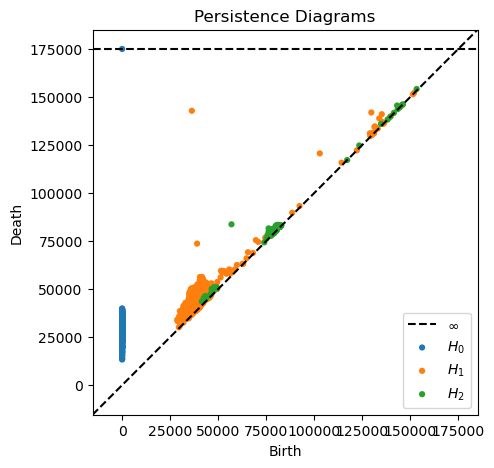

In [6]:
rips_persistence = ripser(SWT_video, maxdim=2)
dgms = rips_persistence['dgms']
plt.figure(figsize = (5,5)) 
plot_diagrams(dgms, title='Persistence Diagrams')

In [ ]:
pca = PCA(n_components=6)

SW_pca = pca.fit(SW_video).transform(SW_video)
plt.figure(figsize = (3.8,1.5))
plt.plot(pca.explained_variance_ratio_, '-*') ;
plt.title('Explained PCA variance -Sliding Window');

In [ ]:
pca = PCA(n_components=8)

SWT_pca = pca.fit(SWT_video).transform(SWT_video)
plt.figure(figsize = (3.8,1.5))
plt.plot(pca.explained_variance_ratio_, '-*') ;
plt.title('Explained PCA variance -Sliding Window');

In [ ]:
# Get the circular coordinates at birth, and for the 2 cocycles with highest persistence
coho_classes = [0, 1]

circular_coords = []

n_lands = 200

cc = CircularCoords(SWT_pca, n_landmarks=n_lands)

for i in coho_classes:
    theta = cc.get_coordinates(perc=0, cocycle_idx=i)
    theta = CMU.to_sinebow(np.pi + CMU.center(theta))
    circular_coords.append(theta)

In [ ]:
#circle-straight vid - Non torus carnivourus flower lookin thing
fig = go.Figure(data=[go.Scatter3d(
    x=SW_pca[:,0], y=SW_pca[:,1], z=SW_pca[:,2], 
    mode ='markers', 
    marker=dict(size = 2.5, color = 'brown')
)] , layout = go.Layout(scene = dict(aspectmode= 'data')))

fig.show()

In [ ]:
#coupled vid 
fig = go.Figure(data=[go.Scatter3d(
    x=SW_pca[:,0], y=SW_pca[:,1], z=SW_pca[:,2], 
    mode ='markers', 
    marker=dict(size = 2.5, color = 'pink')
)] , layout = go.Layout(scene = dict(aspectmode= 'data')))

fig.show()

In [ ]:
#coupled osc vid
fig = go.Figure(data=[go.Scatter3d(
    x=SW_pca[:,1], y=SW_pca[:,2], z=SW_pca[:,3], 
    mode ='markers', 
    marker=dict(size = 2.5, color = 'brown')
)] , layout = go.Layout(scene = dict(aspectmode= 'data')))

fig.show()